# CSV to MySQL

In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='2684',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/Data Analysis/E-commerce (SQL, Python)/Datasates'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
pip install matplotlib.piplot

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.piplot (from versions: none)
ERROR: No matching distribution found for matplotlib.piplot


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "2684",
                            database = "ecommerce")
cur = db.cursor()

# 1. List all unique cities where customers are located.



In [4]:
query = """select distinct upper(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City"])
df

,Customer City
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# 2. Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are:", data[0][0]

('total orders placed in 2017 are:', 315707)

# 3. Find the total sales per category

In [31]:
query = """ select upper(products.product_category), round(sum(payments.payment_value),2) as Total_Sales
from payments
join order_items on payments.order_id = order_items.order_id
join products on order_items.product_id = products.product_id
group by products.product_category; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df


,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,FASHION BAGS AND ACCESSORIES,436316.56
4,BED TABLE BATH,3425107.34
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# 4. Calculate the percentage of orders that were paid in installments.

In [34]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end)/count(*))*100 as payment_installments_percentage 
from payments """

cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]


('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state.

In [7]:
query = """ select customer_state, count(customer_id)
from customers
group by customer_state """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State", "Customer Number"])
df

,State,Customer Number
0,SP,333968
1,SC,29096
2,MG,93080
3,PR,40360
4,RJ,102816
5,RS,43728
6,PA,7800
7,GO,16160
8,ES,16264
9,BA,27040


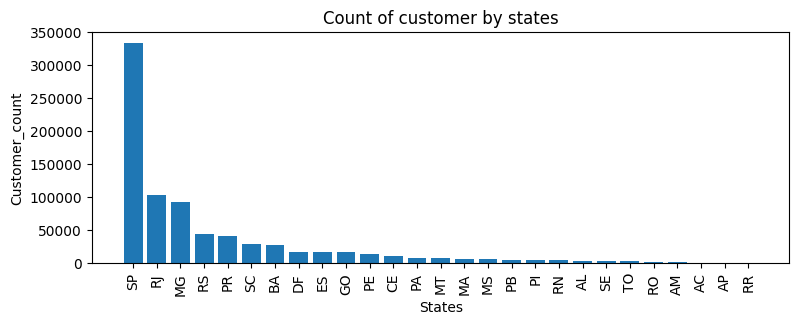

In [9]:
df = df.sort_values(by = "Customer Number", ascending = False)
plt.figure(figsize = (9,3))
plt.bar(df["State"], df["Customer Number"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of customer by states")
plt.show()

# 6. Calculate the number of orders per month in 2018.

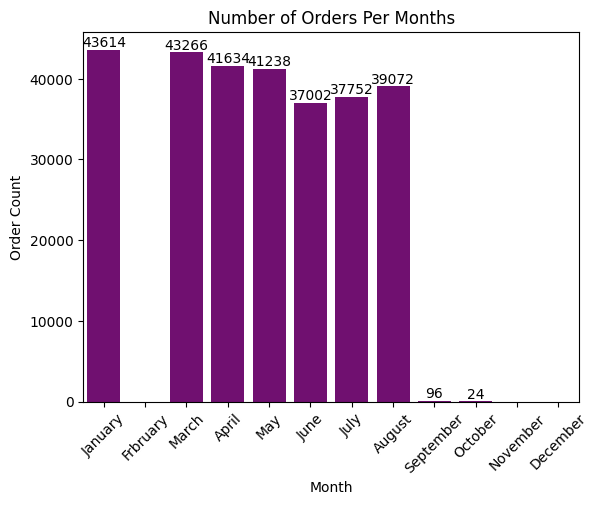

In [19]:
query = """ select monthname(order_purchase_timestamp) as month, count(order_id) as Order_Count 
from orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp) """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Month","Order Count"])
o = ["January", "Frbruary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax = sns.barplot(x = df["Month"], y = df["Order Count"], data = df, order = o, color = "purple")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Number of Orders Per Months")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.


In [22]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders
join order_items on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select upper(customers.customer_city) as customer_city, round(avg(count_per_order.order_count),2) as average_order
from count_per_order
join customers on count_per_order.customer_id = customers.customer_id
group by customers.customer_city; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","average_order"])
df

,customer_city,average_order
0,TREZE TILIAS,7.64
1,INDAIAL,6.69
2,SAO JOSE DOS CAMPOS,6.83
3,SAO PAULO,6.94
4,PORTO ALEGRE,7.05
...,...,...
4105,GUAIRACA,12.00
4106,SAMBAIBA,6.00
4107,JAPARATUBA,6.00
4108,TIBAU DO SUL,6.00


# 8. Calculate the percentage of total revenue contributed by each product category.


In [9]:
query = """ select upper(products.product_category), round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as Percentage_of_total_revenue
from payments
join order_items on payments.order_id = order_items.order_id
join products on order_items.product_id = products.product_id
group by products.product_category
order by  Percentage_of_total_revenue desc; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category","Percentage_of_total_revenue"])
df

,product_category,Percentage_of_total_revenue
0,BED TABLE BATH,64.19
1,HEALTH BEAUTY,62.12
2,COMPUTER ACCESSORIES,59.42
3,FURNITURE DECORATION,53.60
4,WATCHES PRESENT,53.57
...,...,...
69,PC GAMER,0.08
70,HOUSE COMFORT 2,0.06
71,CDS MUSIC DVDS,0.04
72,FASHION CHILDREN'S CLOTHING,0.03


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [25]:
query = """select upper(products.product_category), count(order_items.product_id) as purchased_times, round(avg(order_items.price),2) avg_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category", "Purchased Times", "Average Price"])

arr1 = df["Average Price"]
arr2 = df["Purchased Times"]
x = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is ", x[0][1])

The correlation between product price and the number of times a product has been purchased is  -0.10631514167157566


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [43]:
query = """select * , dense_rank() over(order by total_revenue desc) as "rank" from 
(select sellers.seller_id, round(sum(payments.payment_value),2) as total_revenue
from sellers join order_items
on sellers.seller_id = order_items.seller_id
join payments on order_items.order_id = payments.order_id
group by sellers.seller_id) as T;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller ID", "Total Revenue", "Rank"])
df

,Seller ID,Total Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,14200673.40,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,8630217.12,2
2,4a3ca9315b744ce9f8e9374361493884,8434867.55,3
3,1f50f920176fa81dab994f9023523100,8127095.76,4
4,53243585a1d6dc2643021fd1853d8905,7977286.25,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,537.88,3076
3091,702835e4b785b67a084280efca355756,519.68,3077
3092,4965a7002cca77301c82d3f91b82e1a9,458.08,3078
3093,77128dec4bec4878c37ab7d6169d6f26,426.16,3079


# 11. Calculate the cumulative sales per month for each year.

In [45]:
query = """select Year, Month, round(sum(Payment) over (order by Year, Month),2) as comulative_sales from
(select year(orders.order_purchase_timestamp) As Year, month(orders.order_purchase_timestamp) as Month, round(sum(payments.payment_value),2) as Payment
from orders join payments
on orders.order_id = payments.order_id
group by Year, Month
order by Year) as T;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month", "Comulative Sales"])
df

,Year,Month,Comulative Sales
0,2016,9,7.062720e+03
1,2016,10,1.661596e+06
2,2016,12,1.662146e+06
3,2017,1,5.539811e+06
4,2017,2,1.371323e+07
5,2017,3,2.630942e+07
6,2017,4,3.800748e+07
7,2017,5,5.460921e+07
8,2017,6,6.892495e+07
9,2017,7,8.551167e+07


# 12. Calculate the year-over-year growth rate of total sales.

In [52]:
query = """with CTE as (select year(orders.order_purchase_timestamp) As Year, round(sum(payments.payment_value),2) as Payment
from orders join payments
on orders.order_id = payments.order_id
group by Year
order by Year)
select Year, Payment, round(((Payment - lag(payment,1) over (order by year))/(lag(payment,1) over (order by year)))*100,2) as "YOY % Growth"
from CTE;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Payment", "YOY % Growth"])
df

,Year,Payment,YOY % Growth
0,2016,1.662146e+06,NaN
1,2017,2.029929e+08,12112.7
2,2018,2.435934e+08,20.0


# 13. 5. Identify the top 3 customers who spent the most money in each year.

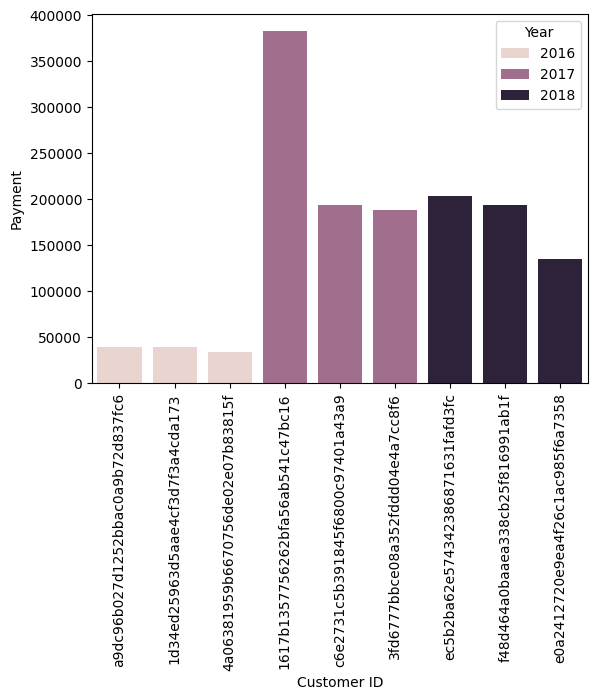

In [56]:
query = """select year, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) as year, orders.customer_id, round(sum(payments.payment_value),2) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value)desc) as "d_rank"
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Customer ID","Payment", "Rank"])
sns.barplot(x = "Customer ID", y = "Payment", hue = "Year", data = df)
plt.xticks(rotation = 90)
plt.show()